In [1]:
import pandas as pd
import os
import torch
import json
import numpy as np

/home/lbcb02/anaconda3/envs/master_37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%run ../Config.ipynb

In [3]:
config = Config()

#### Rmsd's 

In [4]:
rmsd = pd.read_csv(f"{config.data}/rmsd.csv")

In [5]:
rmsd['pdb'].nunique()

280

Obs: There is one pdb missing!

In [6]:
rmsd[rmsd['pdb'] == "4kz6"]['poserank'].value_counts()

2     1
3     1
5     1
6     1
8     1
9     1
10    1
Name: poserank, dtype: int64

Complexes are labeled as correct if they fall within 2.0 Angstroms heavy-atom RMSD of the reference ligand structure, a standard cutoff in the field (see e.g. Ref. 44). Correct poses are labeled “positive,” and those that fall outside the cutoff are labeled as “negative.”

#### Creating label 

In [7]:
label = rmsd.copy()

#### Score similarity 

In [8]:
score = pd.read_json(f"{config.data}/score.json").unstack().reset_index().rename(columns = {"level_0":"pdb", "level_1":"poserank", 0:'similarity'})

#### Merge

In [9]:
label = pd.merge(score, label, left_on= ['pdb','poserank'], right_on = ['pdb','poserank'], how = 'outer').drop_duplicates()

In [10]:
#label.sort_values('similarity', ascending = False).tail(30)

| score | rmsd |
|-------|------|
| rmsd < 2 | -10 |
| 2 < rmsd < 3 | -7 |
| rmsd > 3 | 0 |

| score | match |
|-------|-------|
| 79 | -10 |
| 70 | -7 |
| 66 | 0 |
| 42 | 0 |


In [11]:
# Define the conditions and corresponding scores
conditions_rmsd = [ label['RMSD'] < 2
              ,(label['RMSD'] >= 2) & (label['RMSD'] < 3)
              , label['RMSD'] >= 3]

In [12]:
conditions_similarity = [ label['similarity'] >=80 
              ,(label['similarity'] >= 70) & (label['similarity'] < 80)
              #,(label['similarity'] >= 66) & (label['similarity'] < 70)
              , label['similarity'] < 70 ]

In [13]:
scores_rmsd       = [10, 7, 0]
scores_similarity = [10, 7, 0]

label['rmsd_weight'] = np.select(conditions_rmsd, scores_rmsd, default=np.nan)
label['similarity_weight'] = np.select(conditions_similarity, scores_similarity, default=np.nan)

In [14]:
label["pdb"].nunique()

284

In [15]:
#label['RMSD'].hist()

$$
\frac{{\text{{score\_rmsd}} \times 0.5 + \text{{score\_match}} \times 0.5}}{{20}}
$$


In [16]:
label['weight'] = (label['rmsd_weight']*0.5 + label['similarity_weight']*0.5)/10

In [17]:
label["label"] = label["weight"].apply(lambda x: 1 if x > 0.5 else 0)

In [18]:
label[label['pdb'] == "1ydr"]

,pdb,poserank,similarity,RMSD,rmsd_weight,similarity_weight,weight,label
30,1ydr,1,82.089552,0.57,10.0,10.0,1.00,1
31,1ydr,2,5.970149,3.51,0.0,0.0,0.00,0
32,1ydr,3,13.432836,2.74,7.0,0.0,0.35,0
33,1ydr,4,4.477612,3.76,0.0,0.0,0.00,0
34,1ydr,5,7.462687,3.61,0.0,0.0,0.00,0
35,1ydr,6,47.761194,2.55,7.0,0.0,0.35,0
36,1ydr,7,5.970149,3.78,0.0,0.0,0.00,0
37,1ydr,8,1.492537,10.13,0.0,0.0,0.00,0
38,1ydr,9,26.865672,2.14,7.0,0.0,0.35,0
39,1ydr,10,0.000000,3.77,0.0,0.0,0.00,0


In [19]:
label.head()

,pdb,poserank,similarity,RMSD,rmsd_weight,similarity_weight,weight,label
0,4eor,1,14.545455,4.34,0.0,0.0,0.00,0
1,4eor,2,74.545455,1.16,10.0,7.0,0.85,1
2,4eor,3,7.272727,4.94,0.0,0.0,0.00,0
3,4eor,4,6.363636,4.92,0.0,0.0,0.00,0
4,4eor,5,18.181818,6.54,0.0,0.0,0.00,0


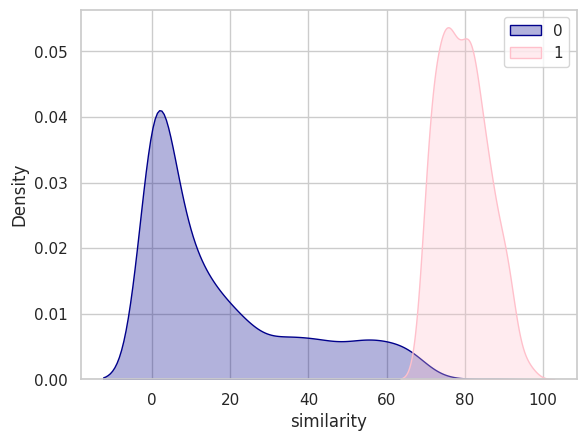

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots()

# Plot density plots for each class with increased transparency
sns.kdeplot(data=label[label['label'] == 0], x='similarity', fill=True, color='darkblue', alpha=0.3, ax=ax, label='0')
sns.kdeplot(data=label[label['label'] == 1], x='similarity', fill=True, color='pink', alpha=0.3, ax=ax, label='1')

# Show the legend
ax.legend()

# Display the plot
plt.show()


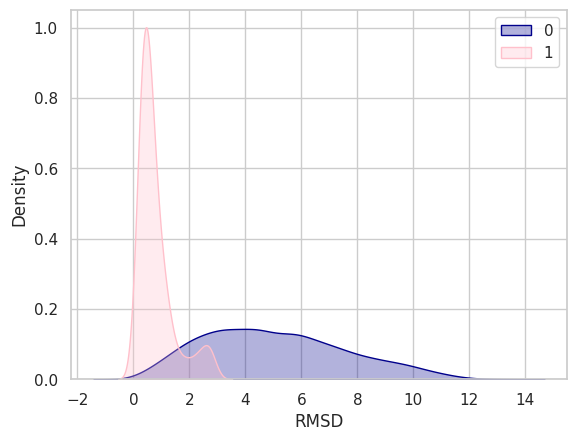

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots()

# Plot density plots for each class with increased transparency
sns.kdeplot(data=label[label['label'] == 0], x='RMSD', fill=True, color='darkblue', alpha=0.3, ax=ax, label='0')
sns.kdeplot(data=label[label['label'] == 1], x='RMSD', fill=True, color='pink', alpha=0.3, ax=ax, label='1')

# Show the legend
ax.legend()

# Display the plot
plt.show()


In [22]:
label['label'].value_counts()

0    2633
1     207
Name: label, dtype: int64

    0    8570
    1    4575
    Name: label, dtype: int64

In [23]:
len(label['label'])

2840

In [24]:
label['pdb'].nunique()

284

In [26]:
label['label'].value_counts(1)

0    0.927113
1    0.072887
Name: label, dtype: float64

#### Creating dict 

In [121]:
# Create the nested dictionary
result_dict = {}
for index, row in label.iterrows():
    pdb = row['pdb']
    poserank = row['poserank']
    label = row['label']
    
    if pdb not in result_dict:
        result_dict[pdb] = {}
    
    result_dict[pdb][poserank] = label

In [122]:
print("label.json saved at:", config.data)

label.json saved at: ../Datahub/Data


In [123]:
# Assuming result_dict is your dictionary
with open(f"{config.data}/label.json", "w") as json_file:
    json.dump(result_dict, json_file)

In [124]:
# Assuming result_dict is your dictionary
with open(f"{config.data}/label.json", "r") as json_file:
    result = json_file.read()

In [125]:
result = pd.read_json(f"{config.data}/label.json")

In [126]:
result

,2qbq,1ydr,3b68,1owh,2vw5,2fxs,2cet,1ydt,2fvd,3ao4,...,1bzc,1bcu,1s38,2yfe,2wvt,2w66,1h23,2xb8,1z6e,3bgz
1,0,1,0,0,1,0,0,0,0,0,...,1,1,1,0,1,1,0,1,1,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Report 

| score | rmsd |
|-------|------|
| rmsd < 2 | -10 |
| 2 < rmsd < 3 | -7 |
| rmsd > 3 | 0 |

| score | match |
|-------|-------|
| > 80 | -10 |
| >= 70 | -7 |
| < 70 | 0| 



| Caso | PDB   | pose | similarity | rmsd | w_rmsd | w_similarity |
|------|-------|------|------------|------|--------|--------------|
| 1    | 2qbq  | 1    | 59.854015  | 1.15 | 10.0   | 0.0          |
| 2    | 2qbp  | 10   | 0.0        | 1.73 | -      | -            |
| 3    | 1ydr  | 10   | 0.0        | 2.17 | -      | -            |
| 4    | 1bzc  | 10   | 0.0        | 1.64 | -      | -            |
